In [26]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
from dotenv import load_dotenv
import os

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#NLP
import jieba
from wordcloud import WordCloud


In [2]:
load_dotenv()
api_key = os.getenv('api_key')

In [3]:
channel_ids = ['UCK7LdglLCApOTaylxX8hW2Q',]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,唐綺陽官方專屬頻道,1030000,249715503,1425,UUK7LdglLCApOTaylxX8hW2Q


In [8]:
playlist_id = "UUK7LdglLCApOTaylxX8hW2Q"

In [9]:
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)

1181

In [11]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Xm6aRPxeqPE,唐綺陽官方專屬頻道,【唐陽雞酒屋】後天努力型選手 ft.鄧惠文,「別透過別人反應來結算自己的人生」\n「創傷很難被逆轉，但我們能重新定義創傷」\n\n我心目...,None,2023-07-11T13:00:10Z,47678,1557,None,107,PT1H10M42S,hd,false
1,QmMsj2979OI,唐綺陽官方專屬頻道,12星座的2023下半年｜2023/7/6直播,下半年運勢直播來了，收拾心緒、一起度過這場精神困境吧\n-\n✨ OPEN將18周年生日慶✨...,None,2023-07-09T04:41:40Z,292751,4432,None,461,PT2H10M40S,hd,false
2,LWqoBH35_-g,唐綺陽官方專屬頻道,7/10-7/16｜星座運勢週報｜唐綺陽,【唐綺陽7/10-7/16星座運勢週報】\n\n★對12星座的影響：\n\n【累的】雙子 天...,None,2023-07-09T01:30:16Z,241402,4245,None,144,PT8M32S,hd,false
3,58SdZrlxcXI,唐綺陽官方專屬頻道,2023金牛座｜下半年運勢｜唐綺陽｜Taurus forecast for the seco...,其他星座的2023下半年運勢：https://bit.ly/46z96dE\n訂閱唐老師：h...,"[12星座, 星座運勢, 占星, 星座性格, 土象星座, 火象星座, 水象星座, 風象星座,...",2023-07-07T03:55:00Z,86426,1556,None,82,PT7M20S,hd,false
4,Is7j9Tl0Tw8,唐綺陽官方專屬頻道,2023雙魚座｜下半年運勢｜唐綺陽｜Pisces forecast for the seco...,其他星座的2023下半年運勢：https://bit.ly/46z96dE\n訂閱唐老師：h...,"[12星座, 星座運勢, 占星, 星座性格, 土象星座, 火象星座, 水象星座, 風象星座,...",2023-07-07T03:55:00Z,83558,1559,None,113,PT8M26S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,bi-VzvFK2d8,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年雙子座,唐立淇星座運勢2014上半年雙子座,None,2014-02-11T06:08:12Z,9303,34,None,2,PT4M30S,sd,false
1177,0bx_PNVX7Eg,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年金牛座,唐立淇星座運勢2014上半年金牛座,None,2014-02-11T06:01:59Z,10237,37,None,7,PT3M29S,sd,false
1178,xG5l_UImKBk,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年牡羊座,唐立淇星座運勢2014上半年牡羊座,None,2014-02-11T05:54:28Z,10024,41,None,3,PT3M25S,sd,false
1179,GWHhmvlpnrc,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年整體星座,唐立淇星座運勢2014上半年整體星座,None,2014-02-11T05:33:53Z,16006,62,None,4,PT5M57S,sd,false


Data pre-processing

In [12]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [13]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [14]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [15]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [16]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [17]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,4242.0,PT1H10M42S
1,7840.0,PT2H10M40S
2,512.0,PT8M32S
3,440.0,PT7M20S
4,506.0,PT8M26S
...,...,...
1176,270.0,PT4M30S
1177,209.0,PT3M29S
1178,205.0,PT3M25S
1179,357.0,PT5M57S


In [18]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [19]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,Xm6aRPxeqPE,唐綺陽官方專屬頻道,【唐陽雞酒屋】後天努力型選手 ft.鄧惠文,「別透過別人反應來結算自己的人生」\n「創傷很難被逆轉，但我們能重新定義創傷」\n\n我心目...,None,2023-07-11 13:00:10+00:00,47678.0,1557.0,NaN,107.0,PT1H10M42S,hd,false,Tuesday,4242.0,0
1,QmMsj2979OI,唐綺陽官方專屬頻道,12星座的2023下半年｜2023/7/6直播,下半年運勢直播來了，收拾心緒、一起度過這場精神困境吧\n-\n✨ OPEN將18周年生日慶✨...,None,2023-07-09 04:41:40+00:00,292751.0,4432.0,NaN,461.0,PT2H10M40S,hd,false,Sunday,7840.0,0
2,LWqoBH35_-g,唐綺陽官方專屬頻道,7/10-7/16｜星座運勢週報｜唐綺陽,【唐綺陽7/10-7/16星座運勢週報】\n\n★對12星座的影響：\n\n【累的】雙子 天...,None,2023-07-09 01:30:16+00:00,241402.0,4245.0,NaN,144.0,PT8M32S,hd,false,Sunday,512.0,0
3,58SdZrlxcXI,唐綺陽官方專屬頻道,2023金牛座｜下半年運勢｜唐綺陽｜Taurus forecast for the seco...,其他星座的2023下半年運勢：https://bit.ly/46z96dE\n訂閱唐老師：h...,"[12星座, 星座運勢, 占星, 星座性格, 土象星座, 火象星座, 水象星座, 風象星座,...",2023-07-07 03:55:00+00:00,86426.0,1556.0,NaN,82.0,PT7M20S,hd,false,Friday,440.0,38
4,Is7j9Tl0Tw8,唐綺陽官方專屬頻道,2023雙魚座｜下半年運勢｜唐綺陽｜Pisces forecast for the seco...,其他星座的2023下半年運勢：https://bit.ly/46z96dE\n訂閱唐老師：h...,"[12星座, 星座運勢, 占星, 星座性格, 土象星座, 火象星座, 水象星座, 風象星座,...",2023-07-07 03:55:00+00:00,83558.0,1559.0,NaN,113.0,PT8M26S,hd,false,Friday,506.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,bi-VzvFK2d8,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年雙子座,唐立淇星座運勢2014上半年雙子座,None,2014-02-11 06:08:12+00:00,9303.0,34.0,NaN,2.0,PT4M30S,sd,false,Tuesday,270.0,0
1177,0bx_PNVX7Eg,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年金牛座,唐立淇星座運勢2014上半年金牛座,None,2014-02-11 06:01:59+00:00,10237.0,37.0,NaN,7.0,PT3M29S,sd,false,Tuesday,209.0,0
1178,xG5l_UImKBk,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年牡羊座,唐立淇星座運勢2014上半年牡羊座,None,2014-02-11 05:54:28+00:00,10024.0,41.0,NaN,3.0,PT3M25S,sd,false,Tuesday,205.0,0
1179,GWHhmvlpnrc,唐綺陽官方專屬頻道,唐立淇星座運勢2014上半年整體星座,唐立淇星座運勢2014上半年整體星座,None,2014-02-11 05:33:53+00:00,16006.0,62.0,NaN,4.0,PT5M57S,sd,false,Tuesday,357.0,0


EDA
Best performing videos

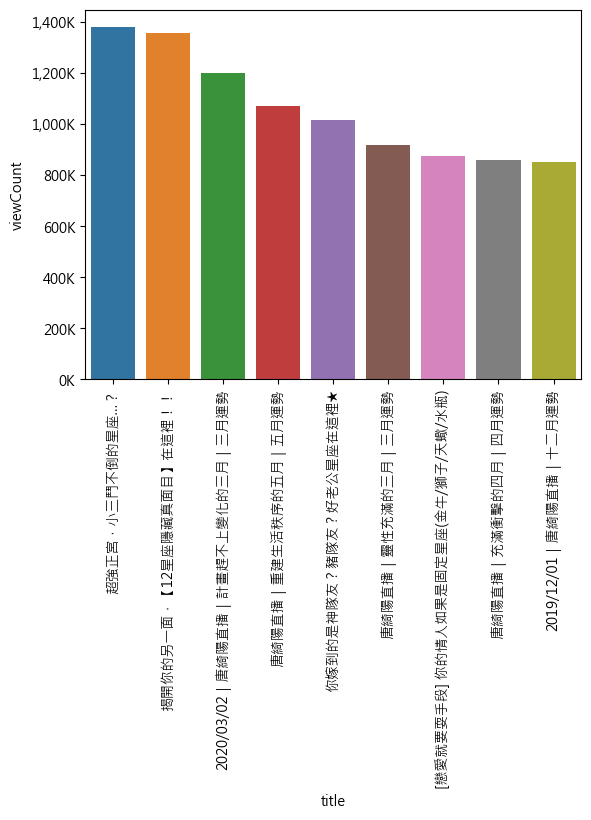

In [20]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

Worst

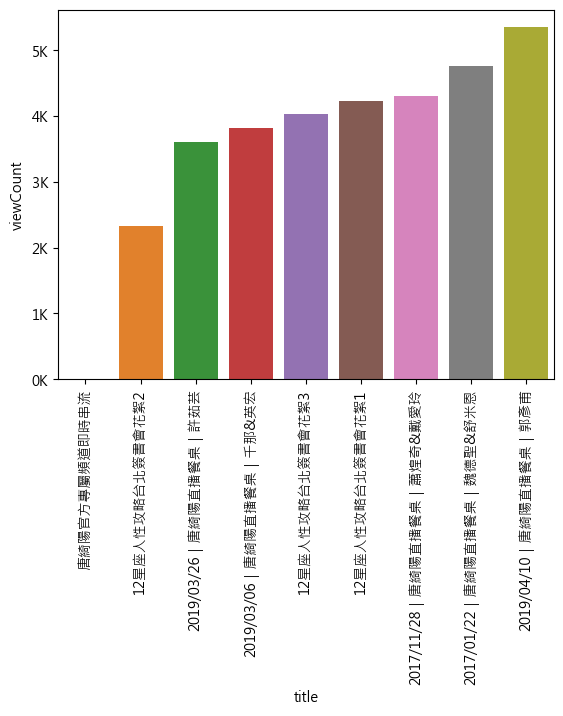

In [21]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

c:\Users\fansy_skkv99a\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

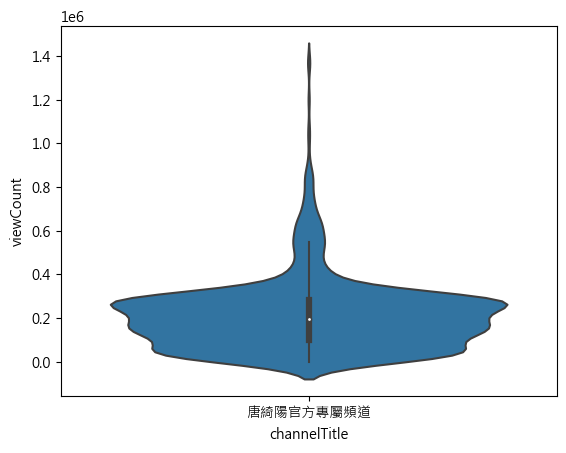

In [22]:

sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

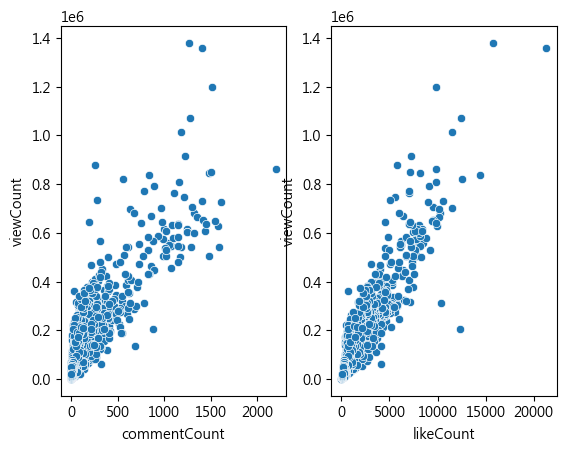

In [23]:
#Views vs. likes and comments
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

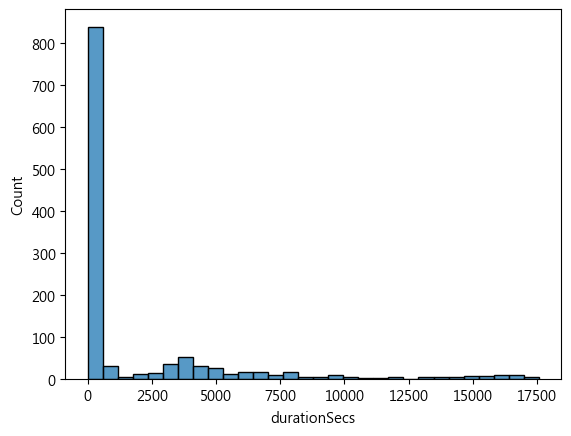

In [24]:
#Video duration
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

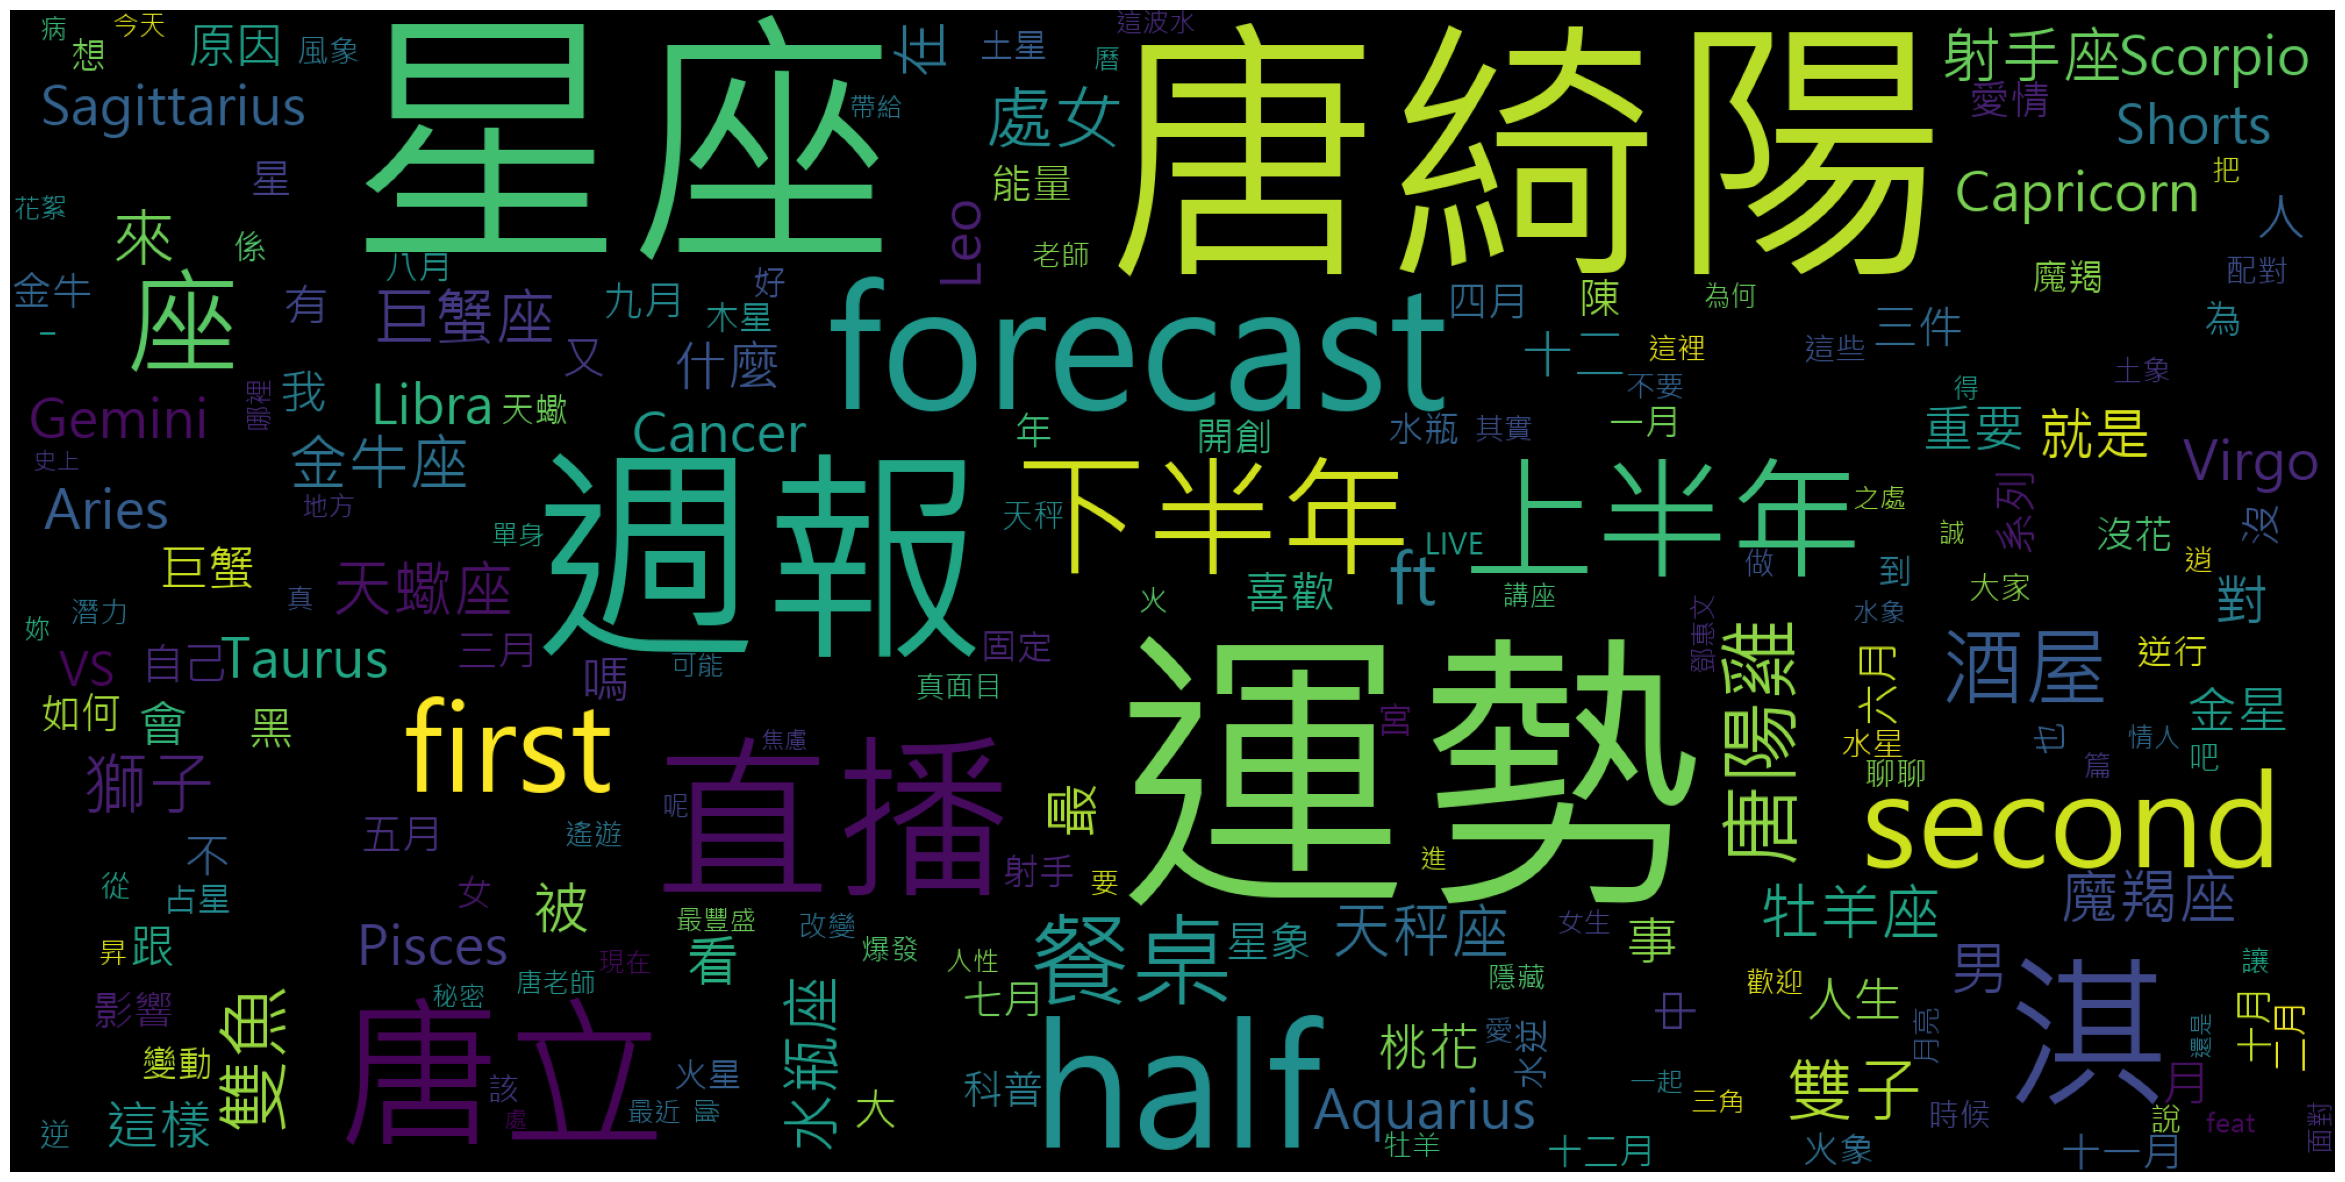

In [32]:
# stop_words = set(stopwords.words('english'))
# video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

# all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])

# Load stopwords from a file
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

all_words_str = ' '.join(video_df['title']) 

# Segment the text data with jieba
seg_list = jieba.cut(all_words_str, cut_all=False)
seg_text = ' '.join(seg_list)


def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(font_path='C:\\Windows\\Fonts\\MSJH.TTC',
                      width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False, stopwords=stopwords).generate(seg_text)
plot_cloud(wordcloud)

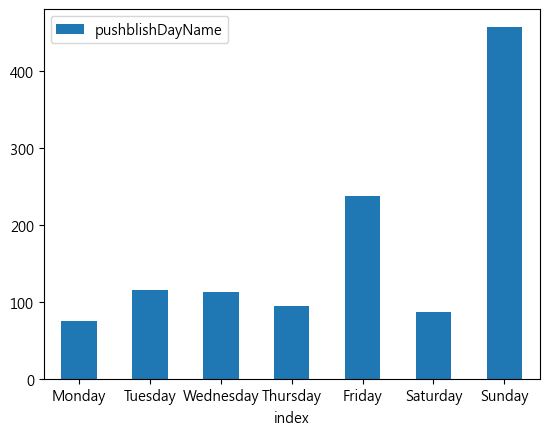

In [30]:
#Upload schedule
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)